## Step 1: Make Datasets

In [1]:
import re
import os
import fnmatch
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.contrib.concurrent import thread_map

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def list_files_by_type(folder_path, file_type):
    filtered_files = []
    for file in os.listdir(folder_path):
        if fnmatch.fnmatch(file, f"*.{file_type}"):
            filtered_files.append(os.path.join(folder_path, file))
    return filtered_files

def process_image(args):
    file_path, label, transform = args  # Unpack the tuple
    image = Image.open(file_path).convert("RGB")
    default_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
    ])
    tensor = default_transform(image)
    if transform:
        tensor = transform(tensor)
    return tensor, torch.tensor(label, dtype=torch.long), file_path

class CIFAKEDataset(Dataset):
    @staticmethod
    def extract_index_and_category(file_path):
        filename = os.path.basename(file_path)
        pattern = r"(\d+)(?: \((\d+)\))?\..+"
        match = re.match(pattern, filename)
        if match:
            index = int(match.group(1))
            category = int(match.group(2)) if match.group(2) else 0
            return index, category
        else:
            return None
    
    @staticmethod
    def load_folder(folder_path, label, category=None, transform=None, num_processes=1):
        print(f"Loading folder: {folder_path}")
        files = list_files_by_type(folder_path, "jpg")
        if category is not None:
            files = [file for file in files if CIFAKEDataset.extract_index_and_category(file)[1] == category]

        # Use process_map from tqdm.contrib.concurrent for better tqdm updates
        results = thread_map(process_image, [(file, label, transform) for file in files], max_workers=num_processes, chunksize=1)

        x = torch.stack([result[0] for result in results])
        y = torch.stack([result[1] for result in results])
        file_paths = [result[2] for result in results]
        return x, y, file_paths
        
    def __init__(self, folder_path, category=None, transform=None, num_processes=1, use_cifake_fold_structure=True):
        self.latest_file_path = None
        
        if use_cifake_fold_structure:
            label_1_folders = [
                os.path.join(folder_path, "train/REAL"),
                os.path.join(folder_path, "test/REAL"),
            ]
            label_0_folders = [
                os.path.join(folder_path, "train/FAKE"),
                os.path.join(folder_path, "test/FAKE"),
            ]
            x1, y1, fp_1 = CIFAKEDataset.load_folder(label_1_folders[0], 1, category, transform, num_processes)
            x2, y2, fp_2 = CIFAKEDataset.load_folder(label_0_folders[0], 0, category, transform, num_processes)
            x3, y3, fp_3 = CIFAKEDataset.load_folder(label_1_folders[1], 1, category, transform, num_processes)
            x4, y4, fp_4 = CIFAKEDataset.load_folder(label_0_folders[1], 0, category, transform, num_processes)
            self.x = torch.cat((x1, x2, x3, x4))
            self.y = torch.cat((y1, y2, y3, y4))
            self.file_paths = fp_1 + fp_2 + fp_3 + fp_4
        else:
            self.x, self.y, self.file_paths = CIFAKEDataset.load_folder(folder_path, 0, None, transform, num_processes)

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, idx):
        self.latest_file_path = self.file_paths[idx]
        return self.x[idx], self.y[idx]
    
    def data_dim(self):
        return self.x[0].size()
    
    def show_example(self, idx):
        x, y = self[idx]
        image_array = x.permute(1, 2, 0).numpy()
        plt.imshow(image_array)
        plt.title(f"Label: {y}")
        plt.axis('off')
        plt.show()

    def latest_file_path(self):
        return self.latest_file_path

## Step 2: Define Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network model following the architecture in the provided diagram
class CIFAKEClassifier(nn.Module):
    def __init__(self):
        super(CIFAKEClassifier, self).__init__()
        # Assuming the input image size is 32x32x3 as per the rescale block in the diagram
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Convolutional layer with 32 outputs
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer with a 2x2 window and stride 2
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Second convolutional layer with 32 outputs
        # Flatten layer will be applied in the forward pass
        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, 1)  # Final dense layer with 1 unit for binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU activation function after first convolution
        x = self.pool(x)  # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply ReLU activation function after second convolution
        x = self.pool(x)  # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor for the dense layer
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first dense layer
        x = torch.sigmoid(self.fc2(x))  # Apply sigmoid activation function for binary classification
        return x

## Step 3: Helper Functions for Training

In [12]:
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import numpy as np
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

# Hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 5

def make_dataloader(dataset, training_data_ratio=0.7):
    # Create the training and testing splits
    train_size = int(training_data_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Dataloader for batch training
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Train the model
def train_model(model, dataloader, epochs):
    # Loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            labels = labels.float()  # BCELoss expects labels to be in float format

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()  # Remove unnecessary dimensions
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

    print('Finished Training')

# Test the model
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(outputs)  # Round to get binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

# Test the model and calculate precision, recall, and specificity
def test_model_with_metrics(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(outputs)  # Round to get binary predictions
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    precision = 100 * precision_score(all_labels, all_predictions)
    recall = 100 * recall_score(all_labels, all_predictions)

    # Calculate specificity
    TN = ((1 - np.array(all_predictions)) * (1 - np.array(all_labels))).sum()
    FN = ((1 - np.array(all_predictions)) * np.array(all_labels)).sum()
    specificity = 100 * TN / (TN + FN)

    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')
    print(f'Precision of the network on the test images: {precision:.2f}%')
    print(f'Recall of the network on the test images: {recall:.2f}%')
    print(f'Specificity of the network on the test images: {specificity:.2f}%')

def evaluate_folder(model, folder_path):
    """Evaluate a single folder of images and return the counts and rates."""
    model.eval()
    
    count_0 = 0
    count_1 = 0
    total_images = 0

    image_list = os.listdir(folder_path)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
    ])
    for image_name in tqdm(image_list, desc="Evaluating images"):
        try:
            image_path = os.path.join(folder_path, image_name)
            image = Image.open(image_path).convert("RGB")
            image = transform(image)
            image = image.unsqueeze(0)  # Add batch dimension
        except Exception as e:
            print(f"Warning: failed to load one image {image_path}, Error: {e}")
            continue

        with torch.no_grad():
            output = model(image).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(output)  # Round to get binary predictions
            label = predicted.item()

        if label == 0:
            count_0 += 1
        else:
            count_1 += 1

        total_images += 1

    rate_0 = (count_0 / total_images) * 100 if total_images > 0 else 0
    rate_1 = (count_1 / total_images) * 100 if total_images > 0 else 0

    return count_0, count_1, rate_0, rate_1

## Step 4: Load Original CIFAKE Data and Train

Loading CIFAKEDataset...
Loading folder: data/CIFAKE\train/REAL


  0%|          | 0/50000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\train/FAKE


  0%|          | 0/50000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\test/REAL


  0%|          | 0/10000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\test/FAKE


  0%|          | 0/10000 [00:00<?, ?it/s]

Dataset loaded successfully!
Dataset length: 120000
Data dimension: torch.Size([3, 32, 32])
Showing example image...


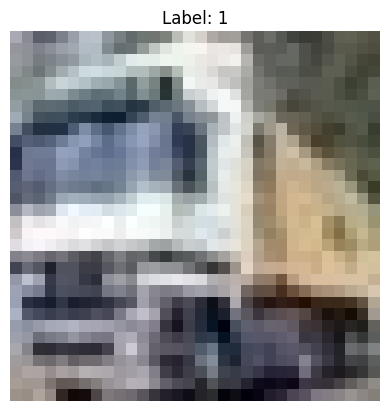

Epoch 1, Batch 100, Loss: 5.4052
Epoch 1, Batch 200, Loss: 4.3547
Epoch 1, Batch 300, Loss: 3.9126
Epoch 1, Batch 400, Loss: 3.7284
Epoch 1, Batch 500, Loss: 3.3896
Epoch 1, Batch 600, Loss: 3.2081
Epoch 1, Batch 700, Loss: 3.0949
Epoch 1, Batch 800, Loss: 3.0079
Epoch 1, Batch 900, Loss: 3.0333
Epoch 1, Batch 1000, Loss: 2.7797
Epoch 1, Batch 1100, Loss: 2.7444
Epoch 1, Batch 1200, Loss: 2.6845
Epoch 1, Batch 1300, Loss: 2.7478
Epoch 2, Batch 100, Loss: 2.3211
Epoch 2, Batch 200, Loss: 2.3203
Epoch 2, Batch 300, Loss: 2.3063
Epoch 2, Batch 400, Loss: 2.3358
Epoch 2, Batch 500, Loss: 2.2801
Epoch 2, Batch 600, Loss: 2.2012
Epoch 2, Batch 700, Loss: 2.2305
Epoch 2, Batch 800, Loss: 2.0416
Epoch 2, Batch 900, Loss: 2.0625
Epoch 2, Batch 1000, Loss: 2.1312
Epoch 2, Batch 1100, Loss: 2.0476
Epoch 2, Batch 1200, Loss: 2.1008
Epoch 2, Batch 1300, Loss: 1.9720
Epoch 3, Batch 100, Loss: 1.8592
Epoch 3, Batch 200, Loss: 1.8631
Epoch 3, Batch 300, Loss: 1.9179
Epoch 3, Batch 400, Loss: 1.8348
Ep

In [4]:
print("Loading CIFAKEDataset...")
dataset_1 = CIFAKEDataset("data/CIFAKE", num_processes=4)
print("Dataset loaded successfully!")
print("Dataset length:", len(dataset_1))
print("Data dimension:", dataset_1.data_dim())
print("Showing example image...")
dataset_1.show_example(0)

# Instantiate the model
model_1 = CIFAKEClassifier()

# Adding training and testing to the notebook
train_loader_1, test_loader_1 = make_dataloader(dataset_1)
train_model(model_1, train_loader_1, epochs)
test_model(model_1, test_loader_1)
test_model_with_metrics(model_1, test_loader_1)

## Step 5: Evaluate Original CIFAKE Data Model on SD 2.1 Images

In [13]:
_, _, s,_ = evaluate_folder(model_1, "data/sd_2_1_dogs_with_modifiers_small")
print(f"Specificity on data/sd_2_1_dogs_with_modifiers: {s}")
_, _, s,_ = evaluate_folder(model_1, "data/sd_2_1_cats_with_modifiers_small")
print(f"Specificity on data/sd_2_1_cats_with_modifiers: {s}")

Evaluating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:40<00:00, 310.25it/s]


Specificity on data/sd_2_1_dogs_with_modifiers: 97.112


Evaluating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:38<00:00, 325.51it/s]

Specificity on data/sd_2_1_cats_with_modifiers: 96.96000000000001


## Step 6: Load 2.1 CIFAKE Data and Train

Loading CIFAKEDataset 2.1...
Loading folder: data/CIFAKE-3\train/REAL


  0%|          | 0/12499 [00:00<?, ?it/s]

Loading folder: data/CIFAKE-3\train/FAKE


  0%|          | 0/12500 [00:00<?, ?it/s]

Loading folder: data/CIFAKE-3\test/REAL


  0%|          | 0/12499 [00:00<?, ?it/s]

Loading folder: data/CIFAKE-3\test/FAKE


  0%|          | 0/12500 [00:00<?, ?it/s]

Dataset loaded successfully!
Dataset length: 49998
Data dimension: torch.Size([3, 32, 32])
Showing example image...


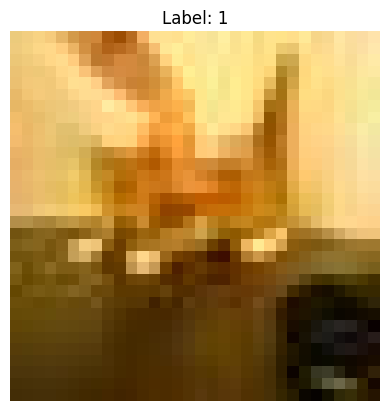

Epoch 1, Batch 100, Loss: 4.7808
Epoch 1, Batch 200, Loss: 2.8958
Epoch 1, Batch 300, Loss: 2.3667
Epoch 1, Batch 400, Loss: 2.5452
Epoch 1, Batch 500, Loss: 2.1211
Epoch 2, Batch 100, Loss: 1.7847
Epoch 2, Batch 200, Loss: 1.8676
Epoch 2, Batch 300, Loss: 1.7247
Epoch 2, Batch 400, Loss: 1.6557
Epoch 2, Batch 500, Loss: 1.4958
Epoch 3, Batch 100, Loss: 1.4471
Epoch 3, Batch 200, Loss: 1.2965
Epoch 3, Batch 300, Loss: 1.3908
Epoch 3, Batch 400, Loss: 1.5096
Epoch 3, Batch 500, Loss: 1.3684
Epoch 4, Batch 100, Loss: 1.3088
Epoch 4, Batch 200, Loss: 1.2152
Epoch 4, Batch 300, Loss: 1.2109
Epoch 4, Batch 400, Loss: 1.2756
Epoch 4, Batch 500, Loss: 1.1841
Epoch 5, Batch 100, Loss: 1.0262
Epoch 5, Batch 200, Loss: 1.0594
Epoch 5, Batch 300, Loss: 1.1564
Epoch 5, Batch 400, Loss: 1.1899
Epoch 5, Batch 500, Loss: 1.0601
Finished Training
Accuracy of the network on the test images: 96.09%
Accuracy of the network on the test images: 96.09%
Precision of the network on the test images: 95.36%
Rec

In [6]:
print("Loading CIFAKEDataset 2.1...")
dataset_2 = CIFAKEDataset("data/CIFAKE-3", num_processes=4)
print("Dataset loaded successfully!")
print("Dataset length:", len(dataset_2))
print("Data dimension:", dataset_2.data_dim())
print("Showing example image...")
dataset_2.show_example(0)

# Instantiate the model
model_2 = CIFAKEClassifier()

# Adding training and testing to the notebook
train_loader_2, test_loader_2 = make_dataloader(dataset_2)
train_model(model_2, train_loader_2, epochs)
test_model(model_2, test_loader_2)
test_model_with_metrics(model_2, test_loader_2)

## Step 7: Evaluate Original CIFAKE Data Model on SD 2.1 Images Again

In [15]:
_, _, s,_ = evaluate_folder(model_2, "data/sd_2_1_dogs_with_modifiers")
print(f"Specificity on data/sd_2_1_dogs_with_modifiers: {s}")
_, _, s,_ = evaluate_folder(model_2, "data/sd_2_1_cats_with_modifiers")
print(f"Specificity on data/sd_2_1_cats_with_modifiers: {s}")
print("=====================")
_, _, s,_ = evaluate_folder(model_2, "data/sd_2_1_dogs_with_modifiers_small")
print(f"Specificity on data/sd_2_1_dogs_with_modifiers: {s}")
_, _, s,_ = evaluate_folder(model_2, "data/sd_2_1_cats_with_modifiers_small")
print(f"Specificity on data/sd_2_1_cats_with_modifiers: {s}")

Evaluating images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [05:32<00:00, 37.58it/s]


Specificity on data/sd_2_1_dogs_with_modifiers: 79.34400000000001


Evaluating images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [05:12<00:00, 39.99it/s]


Specificity on data/sd_2_1_cats_with_modifiers: 67.816


Evaluating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:47<00:00, 262.14it/s]


Specificity on data/sd_2_1_dogs_with_modifiers: 96.39999999999999


Evaluating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:39<00:00, 315.60it/s]

Specificity on data/sd_2_1_cats_with_modifiers: 94.368


## Step 8: Find Top 200 Most Fake 2.1 Dogs

In [17]:
dataset_3 = CIFAKEDataset("data/sd_2_1_dogs_with_modifiers_small", num_processes=4, use_cifake_fold_structure=False)

results = []
for x, y in tqdm(dataset_3, desc="Evaluating images"):
    x = x.unsqueeze(0)
    with torch.no_grad():
        output = model_2(x).squeeze().item()
        file = dataset_3.latest_file_path
        results.append({"file": file, "score": output})

# Sort the list of dictionaries by the "score" key
sorted_results = sorted(results, key=lambda x: x['score'])
most_fakes = sorted_results[:200]
print(most_fakes)

Loading folder: data/sd_2_1_dogs_with_modifiers_small


  0%|          | 0/12500 [00:00<?, ?it/s]

Evaluating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 952.55it/s]

[{'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_302_n.jpg', 'score': 3.3614446692808997e-07}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_3253_n.jpg', 'score': 8.212269904106506e-07}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_5951_n.jpg', 'score': 1.0248169246551697e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_1144_n.jpg', 'score': 1.1179819239259814e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_7507_n.jpg', 'score': 1.2249691963006626e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_7988_n.jpg', 'score': 1.3956869224784896e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_7477_n.jpg', 'score': 1.4647708894699463e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_10162_n.jpg', 'score': 1.5987288861651905e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_11162_n.jpg', 'score': 1.6244734979409259e-06}, {'file': 'data/sd_2_1_dogs_with_modifiers_small\\image_10858_n.jpg', 'score': 1.9